In [1]:
from keras               import layers
from keras               import utils

from keras.models        import Sequential
from keras.layers        import Dense, Activation, Dropout, Embedding, Flatten
from keras.optimizers    import SGD

from nltk.stem           import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer

from keras.preprocessing.text     import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import numpy             as np
import matplotlib.pyplot as plt

import random
import nltk
import json
import pickle
import sys

lemmatizer = WordNetLemmatizer()
nltk.download('punkt')


stemmer = LancasterStemmer()

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')
# with open('/content/drive/My Drive/glove.6B.50d.txt', encoding='utf-8') as f:
# Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
oov_tok = '<OOV>' # out-of-vocabulary words during text_to_sequence calls

In [4]:
# Read data from json file
with open('/content/drive/My Drive/data/intents.json') as file:
    intents = json.load(file)

# intents

# Gather and Tokenize Intents, Labels to One-Hot presentation

In [5]:
# e.g: ["Hi", "Hello", "How are you"]
# to_sequence: {'hi': 1, 'hello': 2, 'how': 3, 'are':4, 'you': 5}
# Hi           -> to_sequence -> [1]       -> padding -> [0, 0, 1]
# Hello        -> to_sequence -> [2]       -> padding -> [0, 0, 2]
# How are you  -> to_sequence-> [3, 4, 5]  -> padding -> [3, 4, 5]

In [6]:
intent_list = []
label_list = []
for (index, intent) in enumerate(intents['intents']):
  intent_list += intent['patterns']
  num_patterns = len(intent['patterns'])
  label_list += [index] * num_patterns
# End - for

tokenizer = Tokenizer(oov_token = oov_tok)
tokenizer.fit_on_texts(intent_list)

word_index = tokenizer.word_index
sequences  = tokenizer.texts_to_sequences(intent_list) # -> [[37, 17],  [12, 3, 2],  [23, 38, 17], ... ]

max_length = len( max(sequences, key=len) )            # max(sequences, key=len) <-> max( len(a) for a in sequences)
vocab_size = len(word_index)

padded         = pad_sequences(sequences)
padded_length  = len(padded[0])                        # e.g: array([[  0,   0,   0,   0,   0,   0,   0,  37,  17],...])
labels         = utils.to_categorical(label_list)        
num_categories = len(labels[0])

113

In [7]:
print (max_length, 'max length of sequence', sequences)  # documents = combination between phrases and intents e.g: [(['Hi', 'there'], 'greeting'), (['How', 'are', 'you'], 'greeting')]
print (num_categories, 'classes/tags', labels)
print (vocab_size, 'unique words', word_index)  # words = all words/vocabularies
print ('padded_length', padded_length)

9 max length of sequence [[37, 17], [12, 3, 2], [23, 38, 17], [60], [61], [39], [40, 41], [24], [42, 2, 43], [44], [62, 63, 6, 2, 24], [64, 65, 66], [18], [45, 2], [46, 25], [67, 18], [18, 8, 68, 19], [12, 2, 69, 47, 19], [7, 2, 48, 13], [7, 47, 2, 70], [12, 2, 48, 71, 25], [7, 72, 23, 73], [12, 6, 74, 14, 75, 26], [9, 14, 20, 49], [76, 19, 27, 28, 29, 20, 77, 14, 78], [28, 79, 20, 80, 8, 10, 81, 14, 26], [82, 20, 83, 30, 14, 26], [9, 4, 5, 49], [84, 85, 6, 4, 5], [4, 5, 31, 86], [15, 21, 6, 87, 4, 5, 32], [4, 5, 31, 88], [15, 21, 6, 33, 8, 4, 5, 50, 89], [4, 5, 8, 10], [90, 10, 4, 5, 50], [91, 4, 5, 32, 8, 10], [34, 4, 5, 32, 92, 93], [34, 19, 27, 22], [34, 22], [28, 29, 94, 95], [96, 22], [33, 22], [51, 8, 16], [97, 8, 16, 6, 98, 10], [15, 21, 6, 33, 16, 31], [16, 51, 8, 10], [99, 100, 16, 101], [37], [12, 3, 2], [23, 38, 17], [39], [40, 41], [24], [42, 2, 43], [44], [18], [45, 2], [46, 25], [], [7, 35, 3, 2, 9], [7, 3, 52, 35], [53, 3, 2, 9], [15, 102, 103, 6, 54, 11], [15, 21, 6, 5

# Training the Model

In [8]:
model = Sequential([
          Embedding(vocab_size+1, 16, input_length=padded_length),
          Flatten(),

          Dense(128, activation='relu'),
          Dropout(0.5),
          Dense(64, activation='relu'),
          Dropout(0.5),
          Dense(num_categories, activation='softmax')
       ])


sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 9, 16)             1824      
_________________________________________________________________
flatten_1 (Flatten)          (None, 144)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               18560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 25)               

In [9]:
#Training and saving the model
epochs = 500
hist = model.fit(padded, labels, epochs=epochs, verbose=2)
model.save('chatbot_model_with_embedding.h5', hist)
print("Completed!")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/500
 - 0s - loss: 3.2242 - accuracy: 0.0488
Epoch 2/500
 - 0s - loss: 3.2205 - accuracy: 0.0366
Epoch 3/500
 - 0s - loss: 3.2164 - accuracy: 0.0610
Epoch 4/500
 - 0s - loss: 3.2078 - accuracy: 0.0488
Epoch 5/500
 - 0s - loss: 3.2051 - accuracy: 0.0732
Epoch 6/500
 - 0s - loss: 3.1886 - accuracy: 0.0976
Epoch 7/500
 - 0s - loss: 3.1801 - accuracy: 0.1220
Epoch 8/500
 - 0s - loss: 3.1836 - accuracy: 0.0488
Epoch 9/500
 - 0s - loss: 3.1679 - accuracy: 0.0732
Epoch 10/500
 - 0s - loss: 3.1660 - accuracy: 0.0610
Epoch 11/500
 - 0s - loss: 3.1523 - accuracy: 0.0976
Epoch 12/500
 - 0s - loss: 3.1343 - accuracy: 0.0488
Epoch 13/500
 - 0s - loss: 3.1246 - accuracy: 0.0854
Epoch 14/500
 - 0s - loss: 3.1390 - accuracy: 0.0854
Epoch 15/500
 - 0s - loss: 3.1358 - accuracy: 0.0854
Epoch 16/500
 - 0s - loss: 3.1155 - accuracy: 0.1098
Epoch 17/500
 - 0s - loss: 3.1040 - accuracy: 0.0976
Epoch 18/500
 - 0s - loss: 3.0660 - accuracy: 0.0854
Epoch 19/500
 - 0s - loss: 3.0684 - accuracy: 0.0854
Ep

dict_keys(['loss', 'accuracy'])


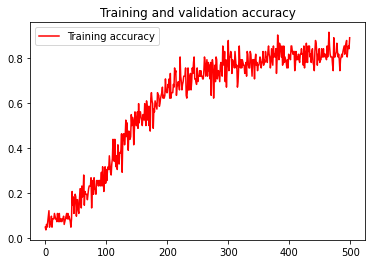

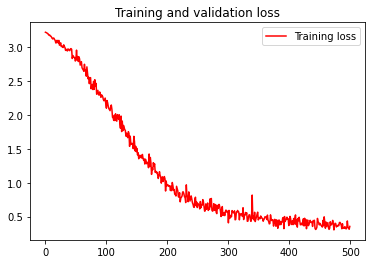

In [10]:
print( hist.history.keys() )

accuracy = hist.history['accuracy']
loss     = hist.history['loss']

plt.plot(range(epochs), accuracy, 'r-', label='Training accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(range(epochs), loss, 'r-', label='Training loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [19]:
def get_response(tag, intents_json):
    # tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if(i['tag']== tag):
            result = random.choice(i['responses'])
            break
    return result

In [27]:
sentence        = 'how are you?'
sequence        = tokenizer.texts_to_sequences([sentence])
padded_sequence = pad_sequences(sequence, maxlen=padded_length)

prediction      = model.predict(padded_sequence)[0]
intent          = intents['intents'][np.argmax(prediction)]
tag             = intent['tag']

res             = get_response(tag, intents)

print('You: ', sentence)
print('Bot: ', res)

[4.2674935e-01 5.5331557e-06 3.0740121e-05 1.8259788e-09 6.3768152e-10
 1.4974838e-09 1.2406582e-06 3.0343343e-12 2.3400315e-10 1.4905137e-09
 2.3998545e-10 5.6080802e-07 1.2859322e-10 5.5683047e-10 5.7314283e-01
 2.0696489e-06 4.7818095e-05 2.7694815e-09 8.8431285e-12 2.5905372e-08
 1.2979525e-06 3.3494320e-08 1.3496977e-05 5.0568460e-06 2.4907523e-09]
You:  how are you?
Bot:  Hi there, how can I help?
